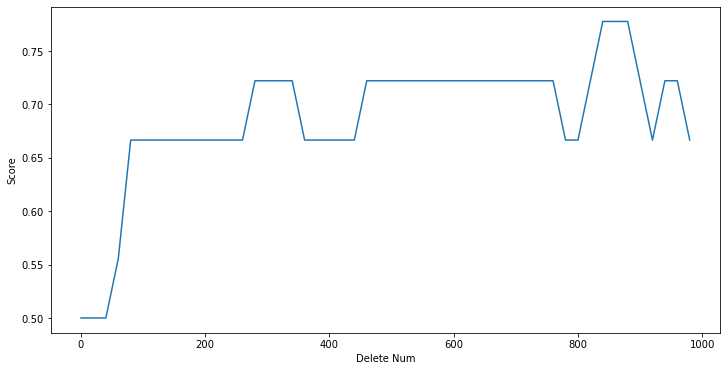

In [60]:
# -*- coding: utf-8 -*-
# !/usr/bin/python3
# @author: chenyuyuan
# @referer: lining0806's code on github
# @date: 2021/3/26

"""
使用Naive Bayes算法进行文本分类
1.导入文本
2.定义文本处理函数，每个文本为一行，并分开存储文本类别，并划分训练集和测试集
3.定义停用词导入函数，导入为set()
4.定义特征词提取函数，删除前N个词后再提取，提取原则为：非数字、非停用词、词长小于5，特征词维度上限为1000
5.定义文本转特征词向量函数，将各类别文本转为0-1向量
6.定义分类函数，并计算出不同N情况下，分类器分类效果
"""

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import re
import os


def text_process(path):
    """
    文本处理函数：导入文本清洗后划分训练集和测试集
    path = '.\\bayes_text_classify\\Database\\Sample'
    """
    data_list = []
    class_list = []
    files = os.listdir(path)
    for file in files:
        file_path = os.path.join(path, file)
        text_list = os.listdir(file_path)
        for text in text_list:
            text_path = os.path.join(file_path, text)
            with open(text_path, 'r', encoding='utf-8') as fp:
                raw = fp.read()
            word_list = list(jieba.cut(raw, cut_all=True))  # 分词
            word_list = [re.sub('\s', '', word) for word in word_list]  # 替换掉'\u3000'之类的Unicode码为空
            word_list = [word for word in word_list if len(word) > 0]  # 删除空字符
            data_list.append(word_list)
            class_list.append(file)
    
    # 划分训练集和测试集
    train_data_list, test_data_list, train_class_list, test_class_list = train_test_split(data_list, class_list, test_size=0.2, random_state=0)
    
    return train_data_list, train_class_list, train_class_list, test_class_list


def get_WordFreq(data_list):
    """
    统计训练集词频，并根据词频大小顺序返回词集
    """
    word_freq = {}
    for text in data_list:
        for word in text:
            word_freq[word] = word_freq.get(word, 0) + 1
    word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True) # 按照词频降序排列，返回由元组组成的列表
    all_word_tuple = list(zip(*word_freq))[0]
    return word_freq, all_word_tuple


def get_stopword(path):
    """
    导入停用词集，返回set类型
    """
    stopword_list = []
    with open(path, 'r', encoding='utf-8') as fp:
        lines = fp.readlines()
        for line in lines:
            stopword_list.append(line.strip())
    stopword_set = set(stopword_list)
    return stopword_set


def get_FeatureWord(word_list, stopword_set, num_feat=1000, del_num=0):
    """
    提取特征词
    del_num: 删除前del_num个词后再提取
    num_feat: 控制特征词数量
    """
    feature_list = []
    for word in word_list[del_num:len(word_list)]:
        if (word not in stopword_set) & (len(word) < 5) & (not word.isdigit()):
            feature_list.append(word)
        if len(feature_list) == 1000:
            break
    return feature_list


def text2vec(train_data, test_data, feature_list):
    """
    将文本转换为0-1向量
    """
    
    def get_FeatVec(text, feature_list):
        """
        将单一文本转换为0-1向量
        """
        feat_vec = [1 if word in text else 0 for word in feature_list]
        return feat_vec
    
    train_feat_vec = [get_FeatVec(text, feature_list) for text in train_data]
    test_feat_vec = [get_FeatVec(text, feature_list) for text in test_data]
    
    return train_feat_vec, test_feat_vec


def textClassify(train_data_list, train_class_list, test_data_list, test_class_list):
    """
    使用训练集数据训练多项式分布贝叶斯分类器，返回测试集分类准确率
    """
    clf = MultinomialNB()
    clf.fit(train_data_list, train_class_list)
    score = clf.score(test_data_list, test_class_list)
    return score


if __name__ == '__main__':
    
    path = 'E:\\jupyter\\data_analysis\\bayes_text_classify\\Database\\Sample'
    train_data_list, train_class_list, train_class_list, test_class_list = text_process(path)
    word_freq, all_word_tuple = get_WordFreq(train_data_list)
    stopword_set = get_stopword('E:\\jupyter\\data_analysis\\bayes_text_classify\\Database\\stopwords_cn.txt')
    
    # 绘制分类器score随del_num变化的曲线
    scores = []
    del_num_list = list(range(0, 1000, 20))
    for del_num in del_num_list:
        feature_list = get_FeatureWord(del_num=del_num, stopword_set=stopword_set, word_list=all_word_tuple)
        train_feat_vec, test_feat_vec = text2vec(train_data_list, test_data_list, feature_list)
        score = textClassify(train_feat_vec, train_class_list, test_feat_vec, test_class_list)
        scores.append(score)
    
    plt.figure(figsize=(12, 6))
    plt.plot(del_num_list, scores)
    plt.xlabel('Delete Num')
    plt.ylabel('Score')
    plt.show()